In [1]:
import torch
import numpy as np
from utils import *
from synthesis import *
import pennylane as qml
from typing import List, Union
import matplotlib.pyplot as plt

np.set_printoptions(precision=8, linewidth=1000)

In [2]:
def circ_ind(ind: List[int], obj: List[int]):
    if ind == [0, 1]:
        qml.CNOT([obj[0], obj[1]])
        qml.CRY(-np.pi / 2, [obj[1], obj[0]])
        qml.X(obj[0])
    elif ind == [0, 2]:
        qml.CNOT([obj[1], obj[0]])
        qml.X(obj[0])
    elif ind == [1, 2]:
        qml.CNOT([obj[0], obj[1]])
        qml.CRY(np.pi / 2, [obj[1], obj[0]])
        qml.X(obj[1])


def circ_zyz(pr, obj: List[int]):
    qml.CRZ(pr[0], [obj[0], obj[1]])
    qml.CRY(pr[1], [obj[0], obj[1]])
    qml.CRZ(pr[2], [obj[0], obj[1]])


def circ_ctrl_state(state: int, ctrl: List[int]):
    if state == 0:
        qml.X(ctrl[1])
        qml.X(ctrl[2])
    elif state == 1:
        qml.CNOT([ctrl[2], ctrl[1]])
        qml.RY(np.pi / 2, ctrl[2])
    elif state == 2:
        pass


def circ_ctrl_ind(ind: List[int], obj: List[int], ctrl: List[int]):
    if ind == [0, 1]:
        qml.ctrl(qml.X(obj), control=ctrl)
        qml.ctrl(qml.RY(-np.pi / 2, ctrl[0]), [obj] + ctrl[1:])
        qml.ctrl(qml.X(ctrl[0]), control=ctrl[1:])
    elif ind == [0, 2]:
        qml.ctrl(qml.X(ctrl[0]), ctrl[1:] + [obj])
        qml.ctrl(qml.X(ctrl[0]), ctrl[1:])
    elif ind == [1, 2]:
        qml.ctrl(qml.X(obj), ctrl)
        qml.ctrl(qml.RY(np.pi / 2, ctrl[0]), [obj] + ctrl[1:])
        qml.ctrl(qml.X(obj), ctrl[1:])


def circ_ctrl_gate(name: str, pr: float, obj: int, ctrl: List[int]):
    name = name.upper()
    if 'RX' in name:
        qml.ctrl(qml.RX(pr, obj), ctrl)
    elif 'RY' in name:
        qml.ctrl(qml.RY(pr, obj), ctrl)
    elif 'RZ' in name:
        qml.ctrl(qml.RZ(pr, obj), ctrl)
    elif 'PS' in name:
        qml.ctrl(qml.PhaseShift(pr, obj), ctrl)
    else:
        raise ValueError(f'Wrong input name of rotation gate {name}')


def two_level_unitary_synthesis(dim: int, pr, ind: List[int], obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    circ_ind(ind, obj)
    circ_zyz(pr, obj)
    qml.adjoint(circ_ind, lazy=False)(ind, obj)


def single_qutrit_unitary_synthesis(dim: int, pr, obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 9:
        raise ValueError(f'The number of params {len(pr)} should be 9')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    index = [[0, 1], [0, 2], [1, 2]]
    pr = pr.reshape(3, 3)
    for i, ind in enumerate(index):
        two_level_unitary_synthesis(dim, pr[i], ind, obj)


def controlled_rotation_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int], ind: List[int], name: str = 'RY'):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 1:
        raise ValueError(f'The number of params {len(pr)} should be 1')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind(ind, obj, ctrl)
    circ_ctrl_gate(name, pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)(ind, obj, ctrl)
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)


def controlled_diagonal_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind([0, 1], obj, ctrl)
    circ_ctrl_gate('RZ', pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 1], obj, ctrl)
    circ_ctrl_ind([0, 2], obj, ctrl)
    circ_ctrl_gate('RZ', pr[1], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 2], obj, ctrl)
    circ_ctrl_gate('PS', pr[2], ctrl[1], ctrl[2])
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)


def two_qutrit_unitary_synthesis(dim: int, pr, obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 102:
        raise ValueError(f'The number of params {len(pr)} should be 102')
    if len(obj) != 4:
        raise ValueError(f'The number of object qubits {len(obj)} should be 4')
    single_qutrit_unitary_synthesis(dim, pr[0:9], obj[2:])  # U1 pr:9
    controlled_diagonal_synthesis(dim, pr[9:12], 1, obj[-1], obj[::-1][1:])  # CD1 pr:3
    single_qutrit_unitary_synthesis(dim, pr[12:21], obj[2:])  # U2 pr:9
    controlled_diagonal_synthesis(dim, pr[21:24], 2, obj[-1], obj[::-1][1:])  # CD2 pr:3
    single_qutrit_unitary_synthesis(dim, pr[24:33], obj[2:])  # U3 pr:9
    controlled_rotation_synthesis(dim, pr[33:34], 1, obj[0], obj[1:], [1, 2])  # RY1_1 pr:1
    controlled_rotation_synthesis(dim, pr[34:35], 2, obj[0], obj[1:], [1, 2])  # RY1_2 pr:1
    single_qutrit_unitary_synthesis(dim, pr[35:44], obj[2:])  # U4 pr:9
    controlled_diagonal_synthesis(dim, pr[44:47], 2, obj[-1], obj[::-1][1:])  # CD3 pr:3
    single_qutrit_unitary_synthesis(dim, pr[47:56], obj[2:])  # U5 pr:9
    controlled_rotation_synthesis(dim, pr[56:57], 1, obj[0], obj[1:], [0, 1])  # RY2_1 pr:1
    controlled_rotation_synthesis(dim, pr[57:58], 2, obj[0], obj[1:], [0, 1])  # RY2_2 pr:1
    single_qutrit_unitary_synthesis(dim, pr[58:67], obj[2:])  # U6 pr:9
    controlled_diagonal_synthesis(dim, pr[67:70], 0, obj[-1], obj[::-1][1:])  # CD4 pr:3
    single_qutrit_unitary_synthesis(dim, pr[70:79], obj[2:])  # U7 pr:9
    controlled_rotation_synthesis(dim, pr[79:80], 1, obj[0], obj[1:], [1, 2])  # RY3_1 pr:1
    controlled_rotation_synthesis(dim, pr[80:81], 2, obj[0], obj[1:], [1, 2])  # RY3_2 pr:1
    single_qutrit_unitary_synthesis(dim, pr[81:90], obj[2:])  # U8 pr:9
    controlled_diagonal_synthesis(dim, pr[90:93], 2, obj[-1], obj[::-1][1:])  # CD5 pr:3
    single_qutrit_unitary_synthesis(dim, pr[93:102], obj[2:])  # U9 pr:9

[[ 3.24275120e-02-8.24144988e-01j -2.58654032e-01-9.40788551e-02j -2.58654032e-01-9.40788551e-02j  3.06461032e-01+2.69569171e-01j -1.02452717e-02+4.46128781e-04j  1.94408372e-03-1.70532475e-03j  1.94408372e-03-1.70532475e-03j -5.13116921e-03-2.31688308e-02j -1.02452717e-02+4.46128781e-04j  1.94408372e-03-1.70532475e-03j  1.94408372e-03-1.70532475e-03j -5.13116921e-03-2.31688308e-02j  9.38636678e-04+3.96675800e-03j -8.23549780e-04+3.40310960e-03j -8.23549780e-04+3.40310960e-03j  1.12092016e-02+1.05832570e-02j]
 [ 1.03308167e-01-3.80588446e-01j  5.43822533e-01+6.13588574e-01j -7.46726644e-03-2.20725250e-01j -2.26398482e-01-2.66659230e-01j  3.03486147e-03+7.12692221e-03j  9.03805521e-04-1.10883138e-02j  9.03805521e-04-1.10883138e-02j -1.13520011e-02+4.40939049e-03j  3.03486147e-03+7.12692221e-03j  9.03805521e-04-1.10883138e-02j  9.03805521e-04-1.10883138e-02j -1.13520011e-02+4.40939049e-03j  3.60602416e-03-2.15404234e-03j  5.53033270e-03+6.39605471e-03j  5.53033270e-03+6.39605471e-03j  2.

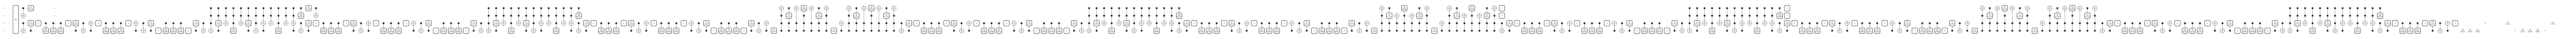

In [3]:
nq = 4
dev = qml.device('default.qubit', nq)


@qml.qnode(dev)
def qutrit_symmetric_ansatz(pr, obj: List[int]):
    dim = 3
    qml.BasisState(psi, range(nq))
    if len(obj) == 2:
        single_qutrit_unitary_synthesis(dim, pr, obj)
    elif len(obj) == 4:
        two_qutrit_unitary_synthesis(dim, pr, obj)
    else:
        raise ValueError('Currently only applicable when the n_qutrits is 1 or 2, which means the n_qubits must be 2 or 4')
    return qml.state()


obj = [0, 1, 2, 3]
psi = [0] * nq
np.random.seed(42)
pr = np.random.rand(102)
qml.draw_mpl(qutrit_symmetric_ansatz, decimals=2)(pr, obj)
matrix = np.zeros([2**nq, 2**nq], dtype=CDTYPE)
for i in range(2**nq):
    psi = [int(j) for j in bin(i)[2:].zfill(nq)]
    res = qutrit_symmetric_ansatz(pr, obj)
    matrix[:, i] = res
matrix = np.array(matrix)
print(approx_matrix(matrix))

[[ 0.52951333-0.71089062j -0.27402203+0.17029516j -0.27402203+0.17029516j -0.07602919-0.01710797j]
 [ 0.28009684-0.02635216j  0.89932707+0.08484707j -0.10067293+0.08484707j -0.29419846-0.03124607j]
 [ 0.28009684-0.02635216j -0.10067293+0.08484707j  0.89932707+0.08484707j -0.29419846-0.03124607j]
 [ 0.22969373+0.05651187j  0.15624818+0.19538607j  0.15624818+0.19538607j  0.68806211+0.58774085j]]


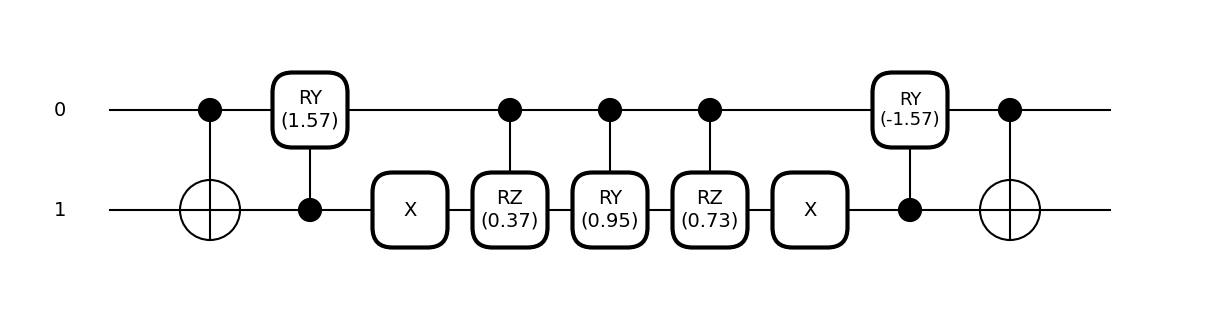

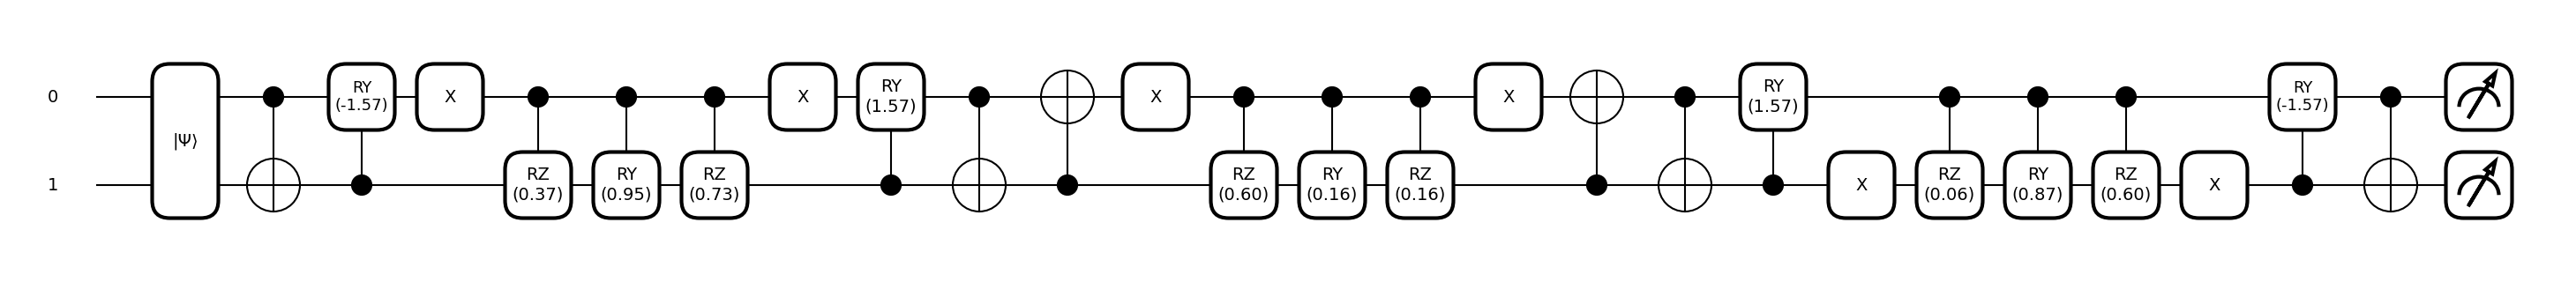

In [4]:
nq = 2
dev = qml.device('default.qubit', nq)


def two_level_unitary_synthesis(dim: int, pr, ind: List[int], obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    circ_ind(ind, obj)
    circ_zyz(pr, obj)
    qml.adjoint(circ_ind, lazy=False)(ind, obj)


@qml.qnode(dev)
def single_qutrit_unitary_synthesis(dim: int, pr, obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 9:
        raise ValueError(f'The number of params {len(pr)} should be 9')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    index = [[0, 1], [0, 2], [1, 2]]
    qml.BasisState(psi, range(nq))
    pr = pr.reshape(3, 3)
    for i, ind in enumerate(index):
        two_level_unitary_synthesis(dim, pr[i], ind, obj)
    return qml.state()


dim = 3
ind = [1, 2]
obj = [0, 1]
psi = [0] * nq
np.random.seed(42)
pr = np.random.rand(3)
qml.draw_mpl(two_level_unitary_synthesis, decimals=2)(dim, pr, ind, obj)
np.random.seed(42)
pr = np.random.rand(9)
qml.draw_mpl(single_qutrit_unitary_synthesis, decimals=2)(dim, pr, obj)
matrix = np.zeros([2**nq, 2**nq], dtype=CDTYPE)
for i in range(2**nq):
    psi = [int(j) for j in bin(i)[2:].zfill(nq)]
    res = single_qutrit_unitary_synthesis(dim, pr, obj)
    matrix[:, i] = res
print(np.array(matrix))

[[ 0.98251615+0.j -0.13164729+0.j -0.13164729+0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.13164729+0.j  0.99125807+0.j -0.00874193+0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.13164729+0.j -0.00874193+0.j  0.99125807+0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0

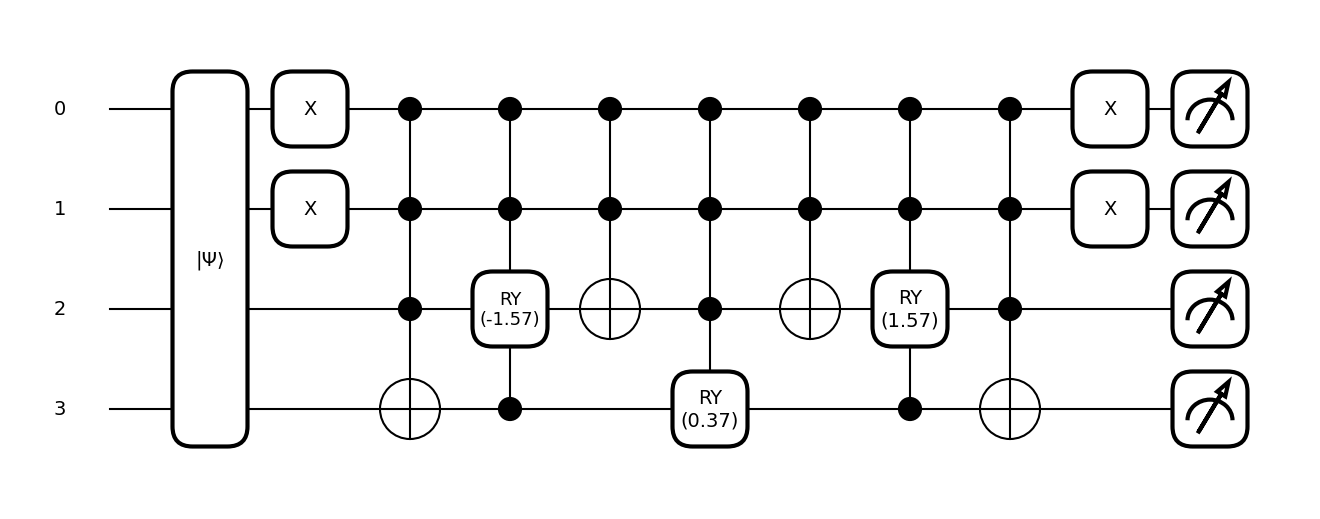

In [5]:
nq = 4
dev = qml.device('default.qubit', wires=nq)


@qml.qnode(dev)
def controlled_rotation_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int], ind: List[int], name: str):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    qml.BasisState(psi, range(nq))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 1:
        raise ValueError(f'The number of params {len(pr)} should be 1')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind(ind, obj, ctrl)
    circ_ctrl_gate(name, pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)(ind, obj, ctrl)
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)
    return qml.state()


dim = 3
state = 0
ind = [0, 1]
name = 'RY'
obj, ctrl = 3, [2, 1, 0]
psi = [0] * nq
np.random.seed(42)
pr = np.random.rand(1)
qml.draw_mpl(controlled_rotation_synthesis, decimals=2)(dim, pr, state, obj, ctrl, ind, name)
matrix = np.zeros([2**nq, 2**nq], dtype=CDTYPE)
for i in range(2**nq):
    psi = [int(j) for j in bin(i)[2:].zfill(nq)]
    res = controlled_rotation_synthesis(dim, pr, state, obj, ctrl, ind, name)
    matrix[:, i] = res
print(np.array(matrix))

[[ 0.99759509+0.06931111j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.67512439+0.73175483j -0.06871883+0.06340069j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.06871883+0.06340069j  0.67512439+0.73175483j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.     

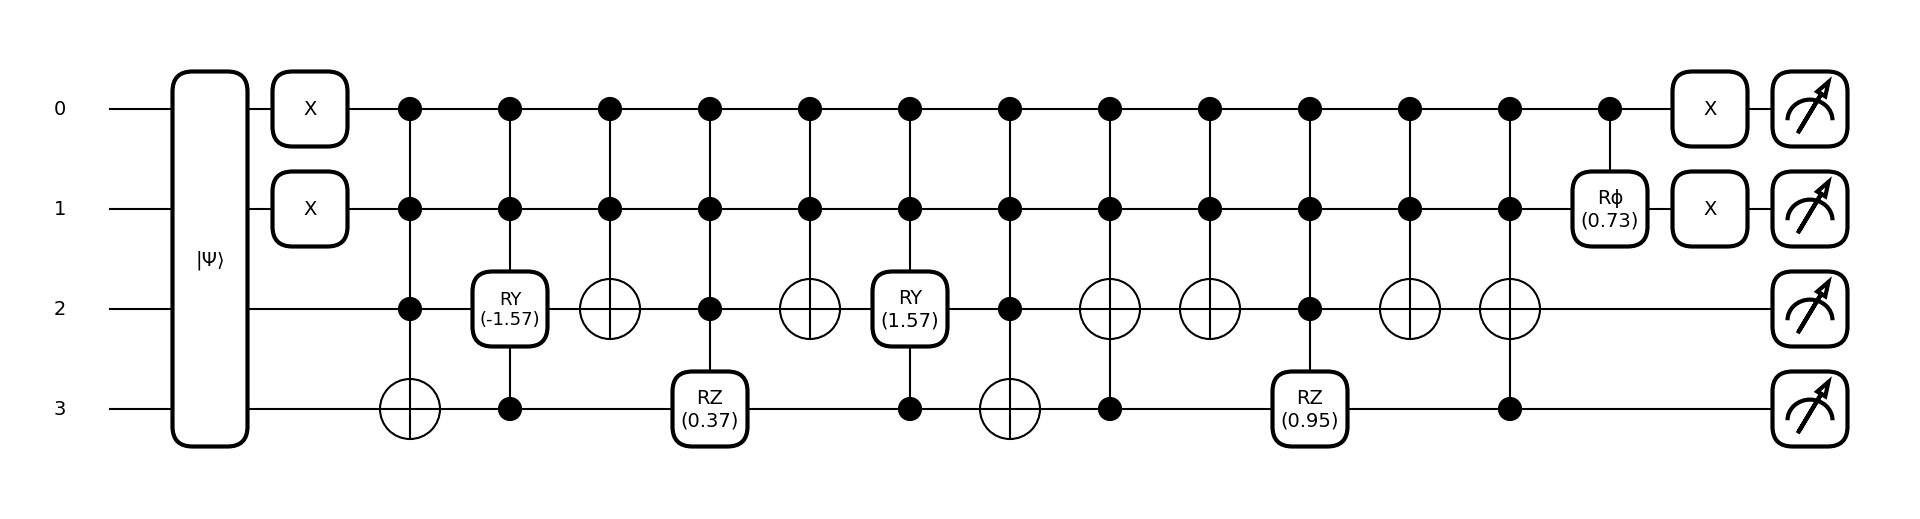

In [6]:
nq = 4
dev = qml.device('default.qubit', wires=nq)


@qml.qnode(dev)
def controlled_diagonal_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    qml.BasisState(psi, range(nq))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind([0, 1], obj, ctrl)
    circ_ctrl_gate('RZ', pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 1], obj, ctrl)
    circ_ctrl_ind([0, 2], obj, ctrl)
    circ_ctrl_gate('RZ', pr[1], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 2], obj, ctrl)
    circ_ctrl_gate('PS', pr[2], ctrl[1], ctrl[2])
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)
    return qml.state()


dim = 3
state = 0
obj, ctrl = 3, [2, 1, 0]
psi = [0] * nq
np.random.seed(42)
pr = np.random.rand(3)
qml.draw_mpl(controlled_diagonal_synthesis, decimals=2)(dim, pr, state, obj, ctrl)
matrix = np.zeros([2**nq, 2**nq], dtype=CDTYPE)
for i in range(2**nq):
    psi = [int(j) for j in bin(i)[2:].zfill(nq)]
    res = controlled_diagonal_synthesis(dim, pr, state, obj, ctrl)
    matrix[:, i] = res
print(matrix)